# Example: Alignment of ECG Recordings
### PulSync:<br>The Heart Rate Variability as a Unique Fingerprint for<br>the Alignment of Sensor Data Across Multiple Wearable Devices

Florian Wolling<br>
Ubiquitous Computing Lab<br>
https://ubicomp.eti.uni-siegen.de<br>
University of Siegen, Germany<br>

### Citation
"[PulSync: The Heart Rate Variability as a Unique Fingerprint for the Alignment of Sensor Data Across Multiple Wearable Devices](https://github.com/fwolling/PulSync/)" by <a href="https://ubicomp.eti.uni-siegen.de/home/team/fwolling.html.en" target="_blank">Florian Wolling</a>, <a href="https://ubicomp.eti.uni-siegen.de/home/team/kristof.html.en" target="_blank">Kristof Van Laerhoven</a>, <a href="https://www.oulu.fi/university/researcher/pekka-siirtola" target="_blank">Pekka Siirtola</a>, and <a href="https://www.oulu.fi/university/researcher/juha-roning" target="_blank">Juha Röning</a>. In *PerHealth 2021: 5th IEEE PerCom Workshop on Pervasive Health Technologies (PerHealth 2021)*, Virtual Event, IEEE, March 2021. <!-- <a href="https://doi.org/" target="_blank">https://doi.org/</a> -->

### Disclaimer
You may use the source code of the developed synchronization tool PulSync for scientific, non-commercial purposes, provided that you give credit to the owners when publishing any work based on it. We would also be very interested to hear back from you if you use our tool or alignment method in any way and are happy to answer any questions or address any remarks related to it.

<br>
<b>Version 0.1</b> (March 2021)

<br>

### References

<span id="ref_s01">**[1]:**</span> "[High precision ECG Database with annotated R peaks, recorded and filmed under realistic conditions](http://researchdata.gla.ac.uk/716/)", Luis Howell and Bernd Porr. University of Glasgow, 2018. <a href="http://dx.doi.org/10.5525/gla.researchdata.716" target="_blank">http://dx.doi.org/10.5525/gla.researchdata.716</a>

### Contents
1. <a href="#Import-of-the-Sample-Data-from-Subject-23">Import of the Sample Data from Subject 23</a>
2. <a href="#Plot-of-the-Original,-Unaligned-ECG-Recordings">Plot of the Original, Unaligned ECG Recordings</a>
3. <a href="#Plot-of-the-Inter-beat-Intervals-as-HRV-Tachograms">Plot of the Inter-beat Intervals as HRV Tachograms</a>
4. <a href="#Plot-of-the-Inter-beat-Intervals-as-HRV-Interval-Functions">Plot of the Inter-beat Intervals as HRV Interval Functions</a>
5. <a href="#Plot-of-the-Interpolated-HRV-Interval-Functions">Plot of the Interpolated HRV Interval Functions</a>
6. <a href="#Plot-of-the-Normalized-Cross-correlation-Function">Plot of the Normalized Cross-correlation Function</a>
7. <a href="#Plot-of-the-Aligned-HRV-Interval-Functions">Plot of the Aligned HRV Interval Functions</a>
8. <a href="#Plot-of-the-Aligned-ECG-Signals">Plot of the Aligned ECG Signals</a>
9. <a href="#Plot-of-the-Metric-of-Synchronicity-as-a-Reference"> Plot of the Metric of Synchronicity as a Reference</a>
10. <a href="#Summary-of-the-Results">Summary of the Results</a>

### Import of the Sample Data from Subject 23

In the following, the application of the *PulSync* tool is demonstrated, to align the manually, inaccurately synchronized ECG recordings from subject 23 of the publicly available dataset 716 of Howell and Porr from the University of Glasgow <a href="#ref_s01">**[1]**</a>.

In [1]:
import pickle
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

# Hide warnings such as FutureWarning.
import warnings
warnings.filterwarnings('ignore')

# Get the standard color panel.
prop_cycle = plt.rcParams['axes.prop_cycle']
std_colors = prop_cycle.by_key()['color']

In [2]:
from PulSync import PulSync  # Load the PulSync tool.

# Load the raw, unfiltered reference data.
# Example from dataset 716, subject 23, Howell and Porr, University of Glasgow, 2018.
file = "gla716_sub23.p"
data = pickle.load(open(str(file), "rb"), encoding="latin1")
# Define the sampling rate of 250 Hz.
fs = 250.0

# Load the Einthoven II ECG lead as the reference signal.
ref     = (data["raw"]["t"], data["raw"]["ii"])     # Time base and ECG signal channel.
ref_pks = data["pks"]["ii"]                         # Index positions of the R peaks.
# Load the chest strap ECG V2-V1 lead as the template signal.
tmp     = (data["raw"]["t"], data["raw"]["chest"])  # Time base and ECG signal channel.
tmp_pks = data["pks"]["chest"]                      # Index positions of the R peaks.

### Plot of the Original, *Unaligned* ECG Recordings

In [3]:
# Plot the ECG signal time series and their R peak annotations.
def plot_ecg(time, signal, peaks=None, labels=None,
             width=15.0, height=5.0,
             title="", xlabel="", ylabel="",
             xlim=None, ylim=None):
    # Convert the single channel data into a list of the single channel.
    if not isinstance(time[0], (list, tuple)):
        time = [time]  # list -> list(list)
        signal = [signal]
        peaks = [peaks]
    # Create a new figure.
    fig = plt.figure(figsize=(width, height))
    ax = plt.axes()
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    # Set the limits.
    if xlim is None:
        ax.set_xlim((np.min(time), np.max(time)))
    else:
        ax.set_xlim(xlim)
    if ylim is None:
        if xlim is not None:
            mins = []
            maxs = []
            for i in range(len(time)):
                # Get the indices closest to the time limits.
                xlim_n = (min(range(len(time[i])), key=lambda x: abs(time[i][x] - xlim[0])),
                          min(range(len(time[i])), key=lambda x: abs(time[i][x] - xlim[1])))
                mins.append(min(signal[i][xlim_n[0]:xlim_n[1]]))
                maxs.append(max(signal[i][xlim_n[0]:xlim_n[1]]))
            pad = (np.max(maxs) - np.min(mins)) * 0.05
            ax.set_ylim((np.min(mins) - pad, np.max(maxs) + pad))
    else:
        ax.set_ylim(ylim)
    # Plot the ECG signals.
    for i in range(len(time)):
        ax.plot(time[i], signal[i], linewidth=0.5, label=("" if labels is None else labels[i]))
    # Plot the peak labels if available.
    if peaks is not None and len(time) == len(peaks):
        for c in range(len(time)):
            ax.plot([time[c][p] for p in peaks[c]], [signal[c][p] for p in peaks[c]],
                    marker="o", markersize=2.0, linestyle="None", color="red")
    # Add the legend.
    if labels is not None:
        ax.legend(loc="upper right", handlelength=1.0, handletextpad=0.5, borderaxespad=0.2, fontsize=10)

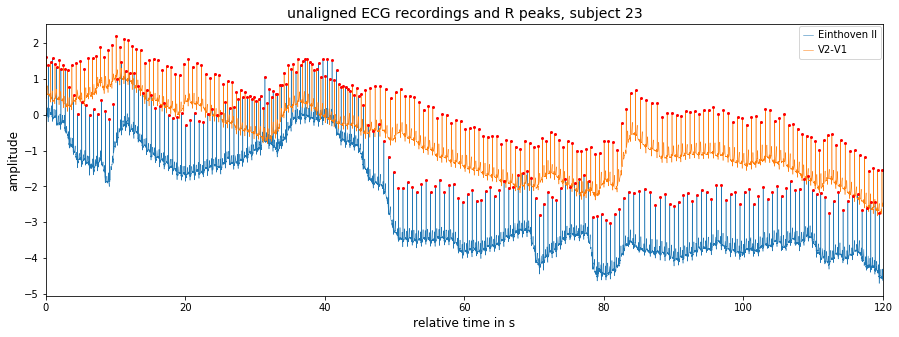

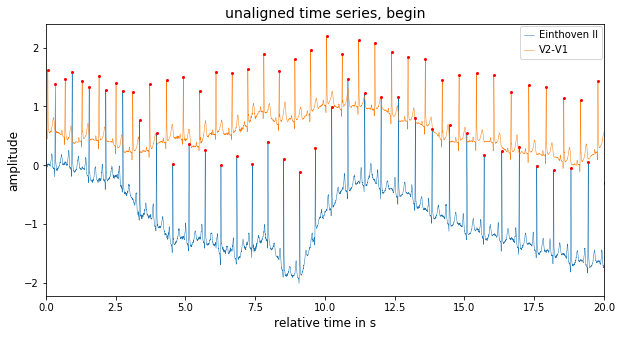

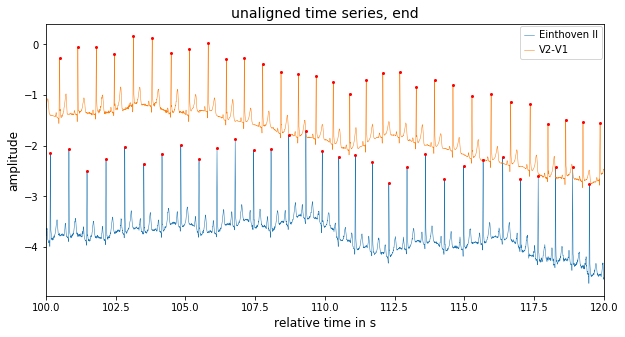

In [4]:
# Plot the example of subject 23.
plot_ecg([ref[0],  tmp[0]],   # Time bases.
         [ref[1],  tmp[1]],   # Signal amplitudes.
         [ref_pks, tmp_pks],  # Peak labels.
         title="unaligned ECG recordings and R peaks, subject 23", xlabel="relative time in s", ylabel="amplitude",
         labels=["Einthoven II", "V2-V1"])

# Length of the windows at the begin and the end of the example in seconds.
win = 20.0
# Plot the begin of the example.
xlim = (min(ref[0]), min(ref[0]) + win)
plot_ecg([ref[0],  tmp[0]],   # Time base and adjusted time base.
         [ref[1],  tmp[1]],   # Signal amplitude.
         [ref_pks, tmp_pks],  # Peak labels.
         title="unaligned time series, begin", xlabel="relative time in s", ylabel="amplitude",
         labels=["Einthoven II", "V2-V1"],
         width=10.0, height=5.0, xlim=xlim)
# Plot the end of the example.
xlim = (max(ref[0]) - win, max(ref[0]))
plot_ecg([ref[0],  tmp[0]],   # Time base and adjusted time base.
         [ref[1],  tmp[1]],   # Signal amplitude.
         [ref_pks, tmp_pks],  # Peak labels.
         title="unaligned time series, end", xlabel="relative time in s", ylabel="amplitude",
         labels=["Einthoven II", "V2-V1"],
         width=10.0, height=5.0, xlim=xlim)

plt.show()

### Plot of the Inter-beat Intervals as HRV Tachograms

In [5]:
# Plot the HRV tachograms of the detected R peaks' inter-beat intervals.
def plot_tachogram(ibi, labels=None,
                   width=10.0, height=5.0,
                   title="", xlabel="", ylabel_l="", ylabel_r="",
                   xlim=None, ylim=None):
    # Convert the single channel data into a list of the single channel.
    if not isinstance(ibi[0], (list, tuple)):
        ibi = [ibi]  # list -> list(list)
    # Create a new figure.
    fig = plt.figure(figsize=(width, height))
    ax_l = plt.axes()
    ax_r = ax_l.twinx()
    ax_l.set_title(title, fontsize=14)
    ax_l.set_xlabel(xlabel, fontsize=12)
    ax_l.set_ylabel(ylabel_l, fontsize=12)
    ax_r.set_ylabel(ylabel_r, fontsize=12)
    # Set the limits.
    if xlim is None:
        xlim = (0, np.max([len(ibi[i])-1 for i in range(len(ibi))]))
    ax_l.set_xlim(xlim)
    # Plot the HRV tachograms.
    for i in range(len(ibi)):
        ax_l.plot(ibi[i], linewidth=0.5, alpha=0.5, color=std_colors[i])
        ax_l.plot(ibi[i], marker="o", markersize=1.5, linestyle="None", color=std_colors[i],
                  label=("" if labels is None else labels[i]))
        ibi_t = [d / fs * 1000.0 for d in ibi[i]]  # Calculate IBI in ms.
        ax_r.plot(ibi_t[i], alpha=0.0)
    # Add the legend.
    if labels is not None:
        ax_l.legend(loc="upper right", handlelength=1.0, handletextpad=0.5, borderaxespad=0.2, fontsize=10)

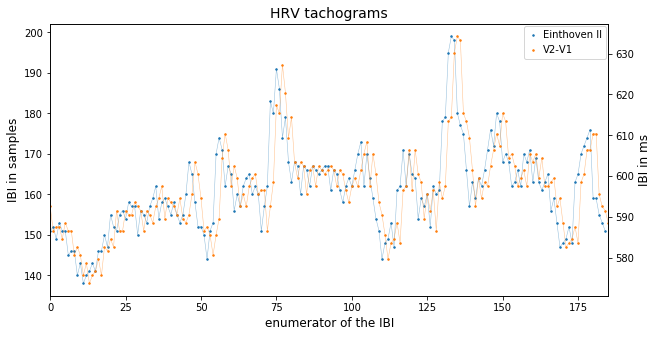

In [6]:
# Determine the R peaks' inter-beat intervals in samples.
ref_ibi = PulSync.pks_to_ibi(ref_pks, mode="samples")
tmp_ibi = PulSync.pks_to_ibi(tmp_pks, mode="samples")

# Plot the HRV tachograms.
plot_tachogram([ref_ibi, tmp_ibi], labels=["Einthoven II", "V2-V1"],
               title="HRV tachograms", xlabel="enumerator of the IBI",
               ylabel_l="IBI in samples", ylabel_r="IBI in ms")
plt.show()

### Plot of the Inter-beat Intervals as HRV Interval Functions

In [7]:
# Plot the HRV interval functions of the detected R peaks' inter-beat intervals.
def plot_hrv(hrv, labels=None,
             width=10.0, height=5.0,
             title="", xlabel="", ylabel_l="", ylabel_r="",
             xlim=None, ylim=None):
    # Convert the single channel data into a list of the single channel.
    if not isinstance(hrv[0], (list, tuple)):
        hrv = [hrv]  # list -> list(list)
    # Create a new figure.
    fig = plt.figure(figsize=(width, height))
    ax_l = plt.axes()
    ax_r = ax_l.twinx()
    ax_l.set_title(title, fontsize=14)
    ax_l.set_xlabel(xlabel, fontsize=12)
    ax_l.set_ylabel(ylabel_l, fontsize=12)
    ax_r.set_ylabel(ylabel_r, fontsize=12)
    # Set the limits.
    if xlim is None:
        xlim = (np.floor(np.min([np.min(hrv[i][0]) for i in range(len(hrv))])),
                np.ceil(np.max([np.max(hrv[i][0]) for i in range(len(hrv))])))
    ax_l.set_xlim(xlim)
    # Plot the HRV interval functions.
    for i in range(len(hrv)):
        hrv_n = [int(round(d * fs)) for d in hrv[i][1]]  # Calculate IBI in samples.
        ax_l.plot(hrv[i][0], hrv_n, linewidth=0.5, alpha=0.5, color=std_colors[i])
        ax_l.plot(hrv[i][0], hrv_n, marker="o", markersize=1.5, linestyle="None", color=std_colors[i],
                  label=("" if labels is None else labels[i]))
        ax_r.plot(hrv[i][0], hrv[i][1], alpha=0.0)
    # Add the legend.
    if labels is not None:
        ax_l.legend(loc="upper right", handlelength=1.0, handletextpad=0.5, borderaxespad=0.2, fontsize=10)

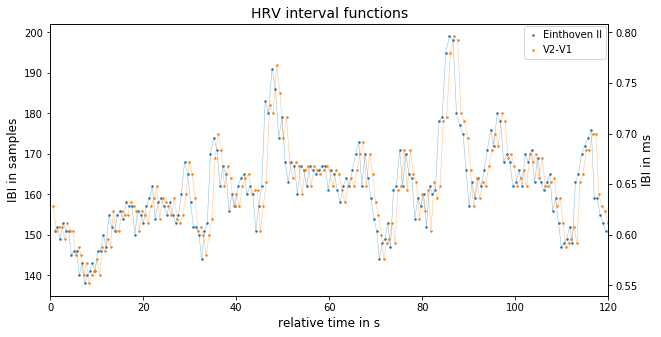

In [8]:
# Derive the HRV interval functions in time domain.
ref_hrv = PulSync.pks_to_hrv(ref_pks, time=ref[0], mode="time")
tmp_hrv = PulSync.pks_to_hrv(tmp_pks, time=tmp[0], mode="time")

# Plot the HRV interval functions.
plot_hrv([ref_hrv, tmp_hrv], labels=["Einthoven II", "V2-V1"], title="HRV interval functions",
         xlabel="relative time in s", ylabel_l="IBI in samples", ylabel_r="IBI in ms")
plt.show()

### Plot of the Interpolated HRV Interval Functions

In [9]:
# Plot the interpolated HRV interval functions.
def plot_hrv_intp(hrv, labels=None,
                  width=10.0, height=5.0,
                  title="", xlabel="", ylabel_l="", ylabel_r="",
                  xlim=None, ylim=None,
                  marker=False):
    # Convert the single channel data into a list of the single channel.
    if not isinstance(hrv[0], (list, tuple)):
        hrv = [hrv]  # list -> list(list)
    # Create a new figure.
    fig = plt.figure(figsize=(width, height))
    ax_l = plt.axes()
    ax_r = ax_l.twinx()
    ax_l.set_title(title, fontsize=14)
    ax_l.set_xlabel(xlabel, fontsize=12)
    ax_l.set_ylabel(ylabel_l, fontsize=12)
    ax_r.set_ylabel(ylabel_r, fontsize=12)
    # Set the limits.
    if xlim is None:
        xlim = (np.floor(np.min([np.min(hrv[i][0]) for i in range(len(hrv))])),
                np.ceil(np.max([np.max(hrv[i][0]) for i in range(len(hrv))])))
    ax_l.set_xlim(xlim)
    # Plot the interpolated HRV interval functions.
    for i in range(len(hrv)):
        hrv_n = [d * fs for d in hrv[i][1]]  # Calculate IBI in samples, interpolated float, not rounded to int.
        ax_l.plot(hrv[i][0], hrv_n, linewidth=0.75, label=("" if labels is None else labels[i]))
        ax_r.plot(hrv[i][0], hrv[i][1], alpha=0.0, label=("" if labels is None else labels[i]))
    # Add the interval marker.
    if marker is not None:
        if marker is True:
            i_tmp = np.argmin([len(hrv[i][0]) for i in range(len(hrv))])
            ax_l.axvspan(hrv[i_tmp][0][0], hrv[i_tmp][0][-1], color=std_colors[i_tmp], alpha=0.05)
        elif isinstance(marker, (list, tuple)):
            ax_l.axvspan(marker[0], marker[1], color=std_colors[marker[2]], alpha=0.05)
    # Add the legend.
    if labels is not None:
        ax_l.legend(loc="upper right", handlelength=1.0, handletextpad=0.5, borderaxespad=0.2, fontsize=10)

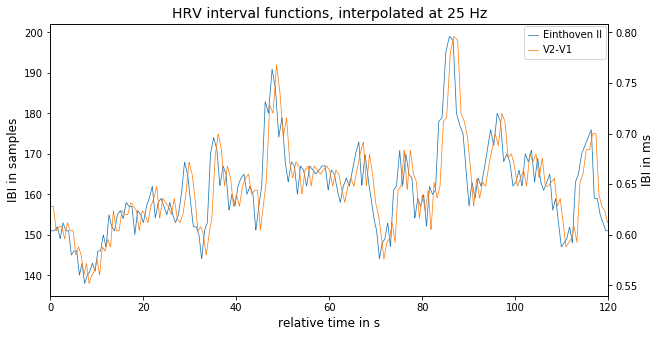

In [10]:
# Define the sampling rate of the interpolation.
intp_fs = 25.0
# Define the interval range of the interpolated time series.
intp_intv = (0.0, 120.0)

# Interpolate the HRV interval functions to the regular time base.
ref_hrv_intp = PulSync.interpolate(ref_hrv[0], ref_hrv[1], interval=intp_intv, fs=intp_fs)
tmp_hrv_intp = PulSync.interpolate(tmp_hrv[0], tmp_hrv[1], interval=intp_intv, fs=intp_fs)

# Plot the resampled HRV interval functions.
plot_hrv_intp([ref_hrv_intp, tmp_hrv_intp],
              labels=["Einthoven II", "V2-V1"], title="HRV interval functions, interpolated at " +
              str(int(round(intp_fs))) + " Hz",
              xlabel="relative time in s", ylabel_l="IBI in samples", ylabel_r="IBI in ms")
plt.show()

### Plot of the Normalized Cross-correlation Function

In [11]:
# Plot the correlation function.
def plot_corr(corr, label=None,
              width=10.0, height=5.0,
              title="", xlabel="", ylabel="",
              xlim=None, ylim=None):
    # Create a new figure.
    fig = plt.figure(figsize=(width, height))
    ax = plt.axes()
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    # Set the limits.
    if xlim is None:
        xlim = (0, len(corr)-1)
    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    # Plot the normalized cross-correlation function.
    ax.axhline(y=0.0, linewidth=0.5, linestyle=":", color="black", zorder=0)
    if np.max(corr) >= 0.75:
        ax.axhline(y=1.0, linewidth=0.5, linestyle=":", color="black", zorder=0)
    if np.min(corr) <= -0.75:
        ax.axhline(y=-1.0, linewidth=0.5, linestyle=":", color="black", zorder=0)
    ax.plot(corr, linewidth=1.0, label=("" if label is None else label))
    ax.plot(np.argmax(corr), np.max(corr), marker="o", markersize=3.0, linestyle="None", color="red", label="max r")
    ax.annotate("i: " + str(int(np.argmax(corr))) + "\n" + "r: " + str("{0:.6f}".format(np.max(corr))),
                xy=(np.argmax(corr), np.max(corr)), textcoords="offset points", xytext=(10, -5),
                fontsize=12, va="top", ha="left")
    # Add the legend.
    if label is not None:
        ax.legend(loc="upper right", handlelength=1.0, handletextpad=0.5, borderaxespad=0.2, fontsize=10)

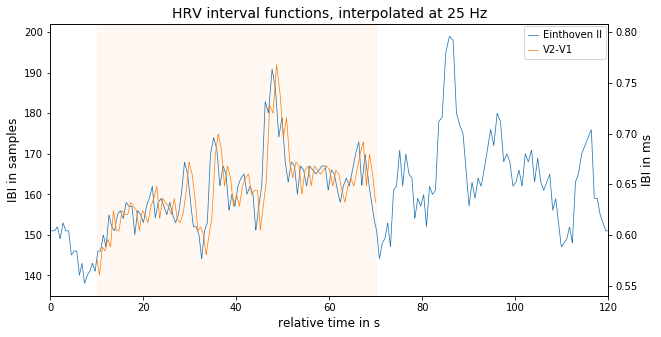

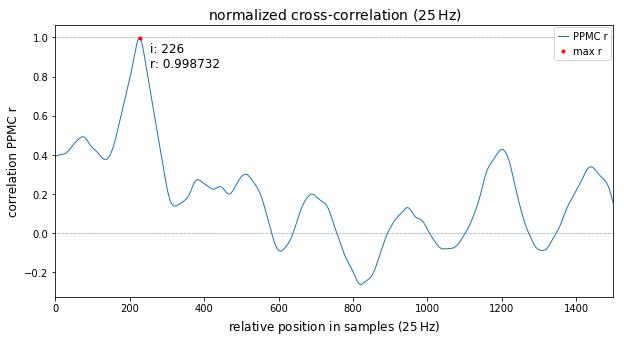

In [12]:
# Reference signal: Einthoven II
ref_corr = ref_hrv_intp
# Template interval: Chest V2-V1
tmp_corr_w_t = (10.0, 70.0)  # Template interval range.
tmp_corr_w_n = (int(round(tmp_corr_w_t[0] * intp_fs)), int(round(tmp_corr_w_t[1] * intp_fs)))  # Range in samples.
# Cut the template interval.
tmp_corr = (tmp_hrv_intp[0][tmp_corr_w_n[0]:tmp_corr_w_n[1]], tmp_hrv_intp[1][tmp_corr_w_n[0]:tmp_corr_w_n[1]])

# Plot the reference and template HRV interval functions at the original positions.
plot_hrv_intp([ref_corr, tmp_corr],
              labels=["Einthoven II", "V2-V1"], title="HRV interval functions, interpolated at " +
              str(int(round(intp_fs))) + " Hz",
              xlabel="relative time in s", ylabel_l="IBI in samples", ylabel_r="IBI in ms", marker=True)

# Correlate the template interval with the reference.
corr = PulSync.correlate(ref=ref_corr[1], tmp=tmp_corr[1])

# Plot the resulting function of the correlation coefficient r.
plot_corr(corr, label="PPMC r",
          title="normalized cross-correlation (" + str(int(round(intp_fs))) + "$\,$Hz)",
          xlabel="relative position in samples (" + str(int(round(intp_fs))) + "$\,$Hz)", ylabel="correlation PPMC r")
plt.show()

### Plot of the *Aligned* HRV Interval Functions

Offset:	0.96 s


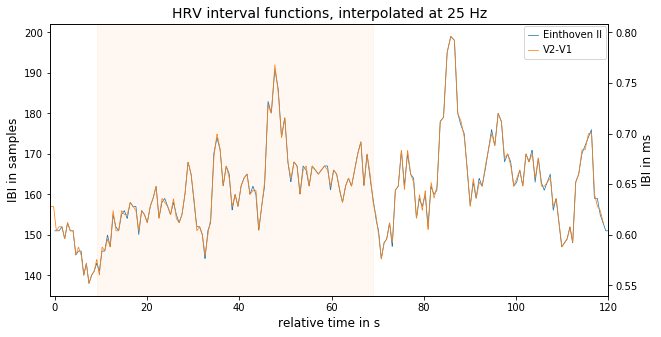

In [13]:
# Determine the offset time, the original window position minus the position of maximum correlation.
corr_max_i = np.argmax(corr)
corr_offset_t = tmp_corr_w_t[0] - (corr_max_i / intp_fs)

print("Offset:\t" + str(round(corr_offset_t, 3)) + " s")

# Align the HRV interval functions.
tmp_hrv_intp_align = ([t - corr_offset_t for t in tmp_hrv_intp[0]] , tmp_hrv_intp[1])

# Plot the aligned HRV interval functions.
plot_hrv_intp([ref_hrv_intp, tmp_hrv_intp_align],
              labels=["Einthoven II", "V2-V1"], title="HRV interval functions, interpolated at " +
              str(int(round(intp_fs))) + " Hz",
              xlabel="relative time in s", ylabel_l="IBI in samples", ylabel_r="IBI in ms",
              marker=(corr_max_i/intp_fs, (corr_max_i/intp_fs) + (tmp_corr_w_t[1] - tmp_corr_w_t[0]), 1))
plt.show()

### Plot of the *Aligned* ECG Signals

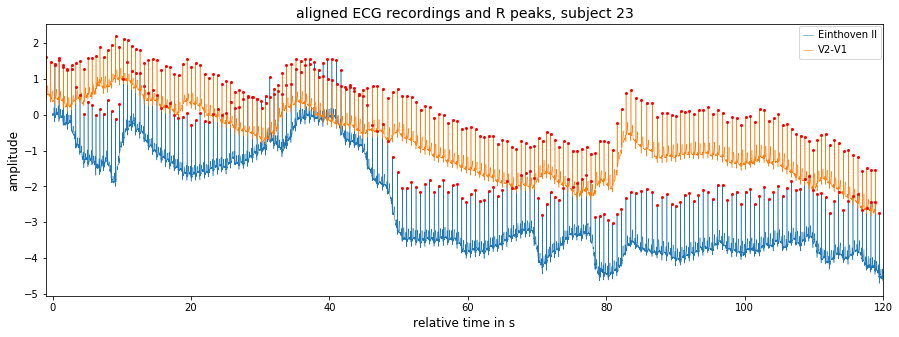

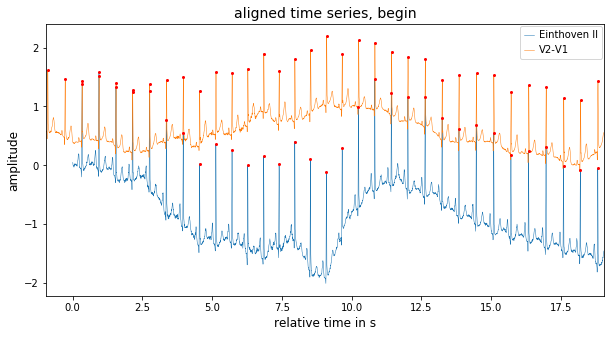

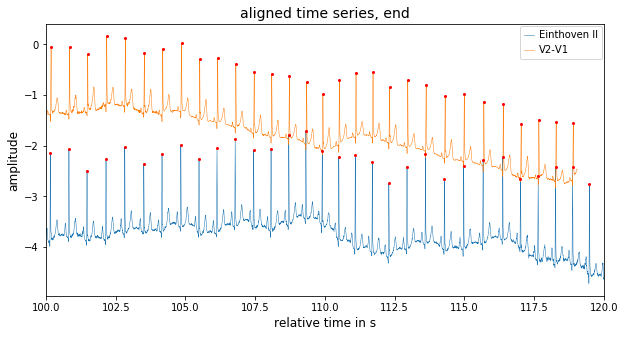

In [14]:
# Apply the determined offset to the template time series.
# Only the time base is shifted, the signal amplitudes and peaks remain the same.
tmp_adj = ([t - corr_offset_t for t in tmp[0]], tmp[1])

# Plot the example of subject 23.
plot_ecg([ref[0],  tmp_adj[0]],  # Time base and adjusted time base.
         [ref[1],  tmp_adj[1]],  # Signal amplitudes.
         [ref_pks, tmp_pks],     # Peak labels.
         title="aligned ECG recordings and R peaks, subject 23", xlabel="relative time in s", ylabel="amplitude",
         labels=["Einthoven II", "V2-V1"])

# Length of the windows at the begin and the end of the example in seconds.
win = 20.0
# Plot the begin of the example.
xlim = (min([min(ref[0]), min(tmp_adj[0])]), min([min(ref[0]), min(tmp_adj[0])]) + win)
plot_ecg([ref[0],  tmp_adj[0]],  # Time base and adjusted time base.
         [ref[1],  tmp_adj[1]],  # Signal amplitude.
         [ref_pks, tmp_pks],     # Peak labels.
         title="aligned time series, begin", xlabel="relative time in s", ylabel="amplitude",
         labels=["Einthoven II", "V2-V1"],
         width=10.0, height=5.0, xlim=xlim)
# Plot the end of the example.
xlim = (max([max(ref[0]), max(tmp_adj[0])]) - win, max([max(ref[0]), max(tmp_adj[0])]))
plot_ecg([ref[0],  tmp_adj[0]],  # Time base and adjusted time base.
         [ref[1],  tmp_adj[1]],  # Signal amplitude.
         [ref_pks, tmp_pks],     # Peak labels.
         title="aligned time series, end", xlabel="relative time in s", ylabel="amplitude",
         labels=["Einthoven II", "V2-V1"],
         width=10.0, height=5.0, xlim=xlim)

plt.show()

### Plot of the Metric of Synchronicity as a Reference

In [15]:
# Plot the error functions.
def plot_err(err_mean, err_std, label=None,
             width=10.0, height=5.0,
             title="", xlabel="", ylabel="",
             xlim=None, ylim=None):
    # Create a new figure.
    fig = plt.figure(figsize=(width, height))
    ax = plt.axes()
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    # Set the limits.
    if xlim is None:
        xlim = (0, len(err_mean)-1)
    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    # Plot the error functions of mean and standard deviation.
    ax.axhline(y=0.0, linewidth=0.5, linestyle=":", color="black", zorder=0)
    ax.plot(err_mean, linewidth=0.75, color=std_colors[2], label=("" if label is None else label[0]))
    ax.plot(err_std, linewidth=0.75, color=std_colors[3], label=("" if label is None else label[1]))
    ax.plot(np.argmin(err_mean), np.min(err_mean), marker="o", markersize=3.0, linestyle="None", color="red")
    ax.plot(np.argmin(err_std), np.min(err_std), marker="o", markersize=3.0, linestyle="None", color="red")
    ax.annotate("i mean: " + str(int(np.argmin(err_mean))) + "\n" + "i std: " + str(int(np.argmin(err_std))),
                xy=(np.argmin(err_mean), np.min(err_mean)), textcoords="offset points", xytext=(15, 30),
                fontsize=12, va="top", ha="left")
    # Add the legend.
    if label is not None:
        ax.legend(loc="upper right", handlelength=1.0, handletextpad=0.5, borderaxespad=0.2, fontsize=10)

In [16]:
# Calculate the indices of the template interval at the original sampling rate.
tmp_sel_i = (int(round(tmp_corr_w_t[0] * fs)), int(round(tmp_corr_w_t[1] * fs)))
tmp_sel = (tmp[0][tmp_sel_i[0]:tmp_sel_i[1]], tmp[1][tmp_sel_i[0]:tmp_sel_i[1]])

# Move the template interval to the raw signal's origin by subtracting the offset.
tmp_sel_pks = [p_d - tmp_sel_i[0] for p_d in tmp_pks if tmp_sel_i[0] <= p_d <= tmp_sel_i[-1]]

err_mean = []
err_std = []
# Shift the template interval along the reference.
for i_p in range(len(ref[1]) - len(tmp_sel[1])):
    # Shift the selected template interval.
    tmp_sel_pks_local = [p + i_p for p in tmp_sel_pks]
    # Determine pairs of proximate peaks in the reference and template.
    tmp_pairs = [[(k_r, k_s) for k_r in ref_pks] for k_s in tmp_sel_pks_local]
    # Determine the distances between the proximate peaks.
    tmp_mins = [np.min([abs(k_p[0] - k_p[1]) for k_p in p]) for p in tmp_pairs]
    # Add the current mean and std errors to the lists.
    err_mean.append(np.mean(tmp_mins))
    err_std.append(np.std(tmp_mins))

# Determine the positions of minimum mean and std error.
err_mean_n = np.argmin(err_mean)
err_std_n  = np.argmin(err_std)

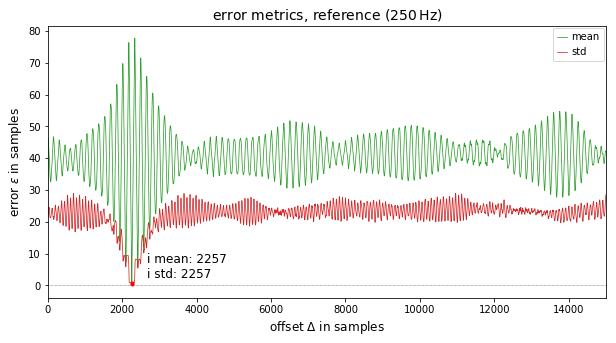

In [17]:
# Plot the error functions of mean and std error.
plot_err(err_mean, err_std, label=["mean", "std"],
         title="error metrics, reference (" + str(int(round(fs))) + "$\,$Hz)",
         xlabel="offset $\Delta$ in samples", ylabel="error $\epsilon$ in samples")
plt.show()

### Summary of the Results

In [18]:
# Calculate the resulting offsets.
offset_corr_n = corr_max_i - tmp_corr_w_n[0]                               # Normalized cross-correlation.
offset_mean_n = err_mean_n - int(round(tmp_corr_w_n[0] * (fs / intp_fs)))  # Mean error metric.
offset_std_n  =  err_std_n - int(round(tmp_corr_w_n[0] * (fs / intp_fs)))  # Standard deviation error metric.

# Print the results.
print("Offset from cross-correlation:    " + str(offset_corr_n) + " samples at  " +
      str(int(round(intp_fs))) + " Hz" + "  ->  " + "{:.3f}".format(round(offset_corr_n / intp_fs, 3)) + " s")
print("Offset from mean error metric:   " + str(offset_mean_n) + " samples at " + str(int(round(fs))) + " Hz" +
      "  ->  " + "{:.3f}".format(round(offset_mean_n / fs, 6)) + " s")
print("Offset from std error metric:    " + str(offset_std_n)  + " samples at " + str(int(round(fs))) + " Hz" +
      "  ->  " + "{:.3f}".format(round(offset_std_n / fs, 6)) + " s")

Offset from cross-correlation:    -24 samples at  25 Hz  ->  -0.960 s
Offset from mean error metric:   -243 samples at 250 Hz  ->  -0.972 s
Offset from std error metric:    -243 samples at 250 Hz  ->  -0.972 s
